In [1]:
# импортируем библиотеки pandas, NumPy, torch,
# модуль random
import torch
import pandas as pd
import numpy as np
import random

# импортируем модели нейронных сетей
from etna.models.nn import (DeepARModel, 
                            TFTModel,
                            RNNModel)

# импортируем классы для генерации признаков и преобразований: 
# LagTransform - для генерации лагов
# DateFlagsTransform - для создания календарных признаков
from etna.transforms import (
    LagTransform, 
    DateFlagsTransform)

# импортируем класс PytorchForecastingDatasetBuilder, чтобы
# подготовить TimeSeriesDataSet - служебный набор 
# PyTorch для обучения нейронной сети
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

# импортируем класс GroupNormalizer для 
# выполнения групповой нормализации
from pytorch_forecasting.data import GroupNormalizer

# импортируем класс TSDataset для манипуляций с данными
from etna.datasets.tsdataset import TSDataset
# импортируем класс Pipeline для последовательного выполнения
# цепочки преобразований и/или конструирования признаков
from etna.pipeline import Pipeline
# импортируем классы для вычисления метрик
from etna.metrics import MAE, SMAPE, MAPE
# импортируем функцию plot_backtest() для визуализации
# результатов перекрестной проверки
from etna.analysis import plot_backtest

# пишем функцию для воспроизводимости результатов
def set_seed(seed: int = 42):
    """
    Задает сиды для воспроизводимости результатов.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# отключаем предупреждения    
import warnings
warnings.filterwarnings('ignore')

# настроим визуализацию
%config InlineBackend.figure_format = 'retina'

/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/etna/settings.py:61: UserWarning: `tsfresh` is not available, to install it, run `pip install tsfresh==0.19.0 && pip install protobuf==3.20.1`
  warnings.warn(


In [3]:
?PytorchForecastingDatasetBuilder

Мы видим довольно страшную сигнатуру, но не стоит паниковать, мы рассмотрим эти параметры далее.

* `max_encoder_length` &mdash; максимальная длина кодировщика – длина истории, исходя из которой модель будет строить признаки

* `min_encoder_length` &mdash; минимальная длина кодировщика – длина истории, исходя из которой модель будет строить признаки. По умолчанию равна max_encoder_length

* `min_prediction_idx` &mdash; минимальный момент времени time_idx, с которого начинается прогнозирование. Этот параметр может быть полезен для создания проверочной или тестовой выборки

* `max_prediction_length` &mdash; максимальная длина декодировщика - наш горизонт прогнозирования

* `min_prediction_length` &mdash; минимальная длина декодировщика (прогнозирования). Значение по умолчанию равно max_prediction_length

* `static_categoricals` &mdash; список статичных категориальных признаков, значения которых не меняются со временем. Например, если мы используем несколько сегментов, это могут быть некоторые его характеристики, включая идентификатор: "segment". Записи могут быть также списками, которые затем кодируются вместе (например, полезно для категорий продуктов)

* `static_reals` &mdash; список вещественных признаков, которые не меняются со временем

* `time_varying_known_categoricals` &mdash; список категориальных признаков, значения которых изменяются во времени и известны в будущем. Записи могут быть также списками, которые затем кодируются вместе (например, полезно для специальных дней или категорий промо-активности);

* `time_varying_known_reals` &mdash; список вещественных признаков, значения которых изменяются во времени и известны в будущем, например, цена продукта, но не спрос на продукт. Теперь необходимо добавить в список переменную "time_idx";

* `time_varying_unknown_categoricals` &mdash; список категориальных признаков, значения которых изменяются во времени и не известны в будущем.  Записи могут быть также списками, которые затем кодируются вместе (например, полезно для категорий погоды)

* `time_varying_unknown_reals` &mdash; список вещественных признаков, значения которых изменяются во времени и не известны в будущем.  Для задачи прогнозирования это будут значения зависимой переменной. Задаем параметр равным `["target"]`

* `variable_groups` &mdash; словарь, сопоставляющий имя со списком признаков. Имя должно присутствовать в аргументе категориального или вещественного значения, чтобы иметь возможность кодировать или стандартизировать признаки по группам. Это позволит эффективно объединять категориальные признаки, особенно полезно, если категориальный признак может иметь несколько значений одновременно. Примером могут служить праздники, которые могут перекрываться

* `constant_fill_strategy` &mdash; словарь признаков с константами для заполнения пропущенных значений при наличии гэпов в последовательности (по умолчанию используется стратегия forward fill). Значения будут использоваться, только если allow_missing_timesteps=True. Часто используется для обозначения того, что спрос был равен 0, если значения отсутствуют в наборе данных

* `allow_missing_timesteps` &mdash; разрешение автоматического заполнения пропущенных временных меток. Пропущенные значения относятся к гэпам в time_idx. Например, если определенный временной ряд имеет только значения для меток времени 1, 2, 4, 5, значение для метки времени 3 будет создана на лету

* `lags` &mdash; словарь признаков, сопоставленных со списком лагов. Лаги могут быть полезны для моделирования сезонности моделей. Если вы знаете сезонность ваших данных, добавьте соответствующие лаги на основе зависимой переменной. Лаги должны быть не больше самого короткого временного ряда, так как все временные ряды будут обрезаны по наибольшему значению лага, чтобы предотвратить появление значений NA. Лаги должны быть указаны в параметрах time_varying_known_reals. По умолчанию лаги отсутствуют

* `add_relative_time_idx` &mdash; добавлять ли в качестве признака индекс - относительную метку времени. Индекс будет находиться в диапазоне от encoder_length до prediction_length

* `add_target_scales` &mdash; добавлять ли параметры стандартизации зависимой переменной к вещественным признакам, которые не меняются со временем

* `add_encoder_length` &mdash; добавлять ли длину декодировщика к списку вещественных признаков, которые не меняются со временем. По умолчанию "auto", то есть True, если min_encoder_length != max_encoder_length

* `target_normalizer` &mdash; класс-трансформер для стандартизации зависимых переменных в разных сегментах. Возможные значения TorchNormalizer, GroupNormalizer, NaNLabelEncoder, EncoderNormalizer, либо None. По умолчанию соответствующий класс выбирается автоматически

* `categorical_encoders` &mdash; словарь классов-трансформеров scikit-learn для кодирования категориальных признаков. Если у вас есть ненаблюдаемые категории в будущем, вы можете использовать NaNLabelEncoder с add_nan=True. По умолчанию эффективно используется LabelEncoder от sklearn. Предобученные классы не будут обучаться повторно

* `scalers` &mdash; словарь классов scikit-learn для стандартизации. По умолчанию используется класс StandardScaler. Другие варианты: EncoderNormalizer, GroupNormalizer или классы scikit-learn StandarScaler, RobustScaler, либо None. Предобученные классы не будут обучаться повторно (за исключением EncoderNormalizer)

In [2]:
# задаем сиды для воспроизводимости
set_seed()

In [3]:
# загружаем набор, в котором каждому сегменту
# соответствует свой временной ряд
original_df = pd.read_csv('Data/example_dataset.csv')
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


In [4]:
# конвертируем датафрейм в формат ETNA
df = TSDataset.to_dataset(original_df)
# превращаем датафрейм в объект TSDataset, 
# задав частоту временного ряда
ts = TSDataset(df, freq='D')
ts.head()

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


In [5]:
# задаем горизонт прогнозирования 
# - 7 меток времени (7 дней)
HORIZON = 7

In [6]:
# создаем модель DeepAR
model_deepar = DeepARModel(
    encoder_length=HORIZON,
    decoder_length=HORIZON,
    trainer_params=dict(max_epochs=150, 
                        gpus=0, 
                        gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

# задаем метрики
metrics = [SMAPE(), MAPE(), MAE()]

# создаем конвейер
pipeline_deepar = Pipeline(model=model_deepar, 
                           horizon=HORIZON)

In [7]:
# выполняем перекрестную проверку расширяющимся окном
metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.3min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 1.6 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


In [8]:
# смотрим метрики по сегментам
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
3,segment_a,11.622650,11.381022,65.275085,0
3,segment_a,1.294015,1.288919,7.104784,1
3,segment_a,10.569916,13.412647,55.388624,2
2,segment_b,4.495150,4.403549,11.666813,0
2,segment_b,2.850603,2.782389,7.291846,1
2,segment_b,11.010539,12.385316,26.938982,2
0,segment_c,8.111557,7.994354,15.536285,0
0,segment_c,27.885433,24.203326,65.042090,1
0,segment_c,19.935029,23.219835,35.505216,2
1,segment_d,12.637055,11.845550,116.453421,0


In [9]:
# вычислим усредненное значение SMAPE
score = metrics_deepar['SMAPE'].mean()
print(f"Усредненное значение SMAPE для DeepAR: {score:.3f}")

Усредненное значение SMAPE для DeepAR: 10.681


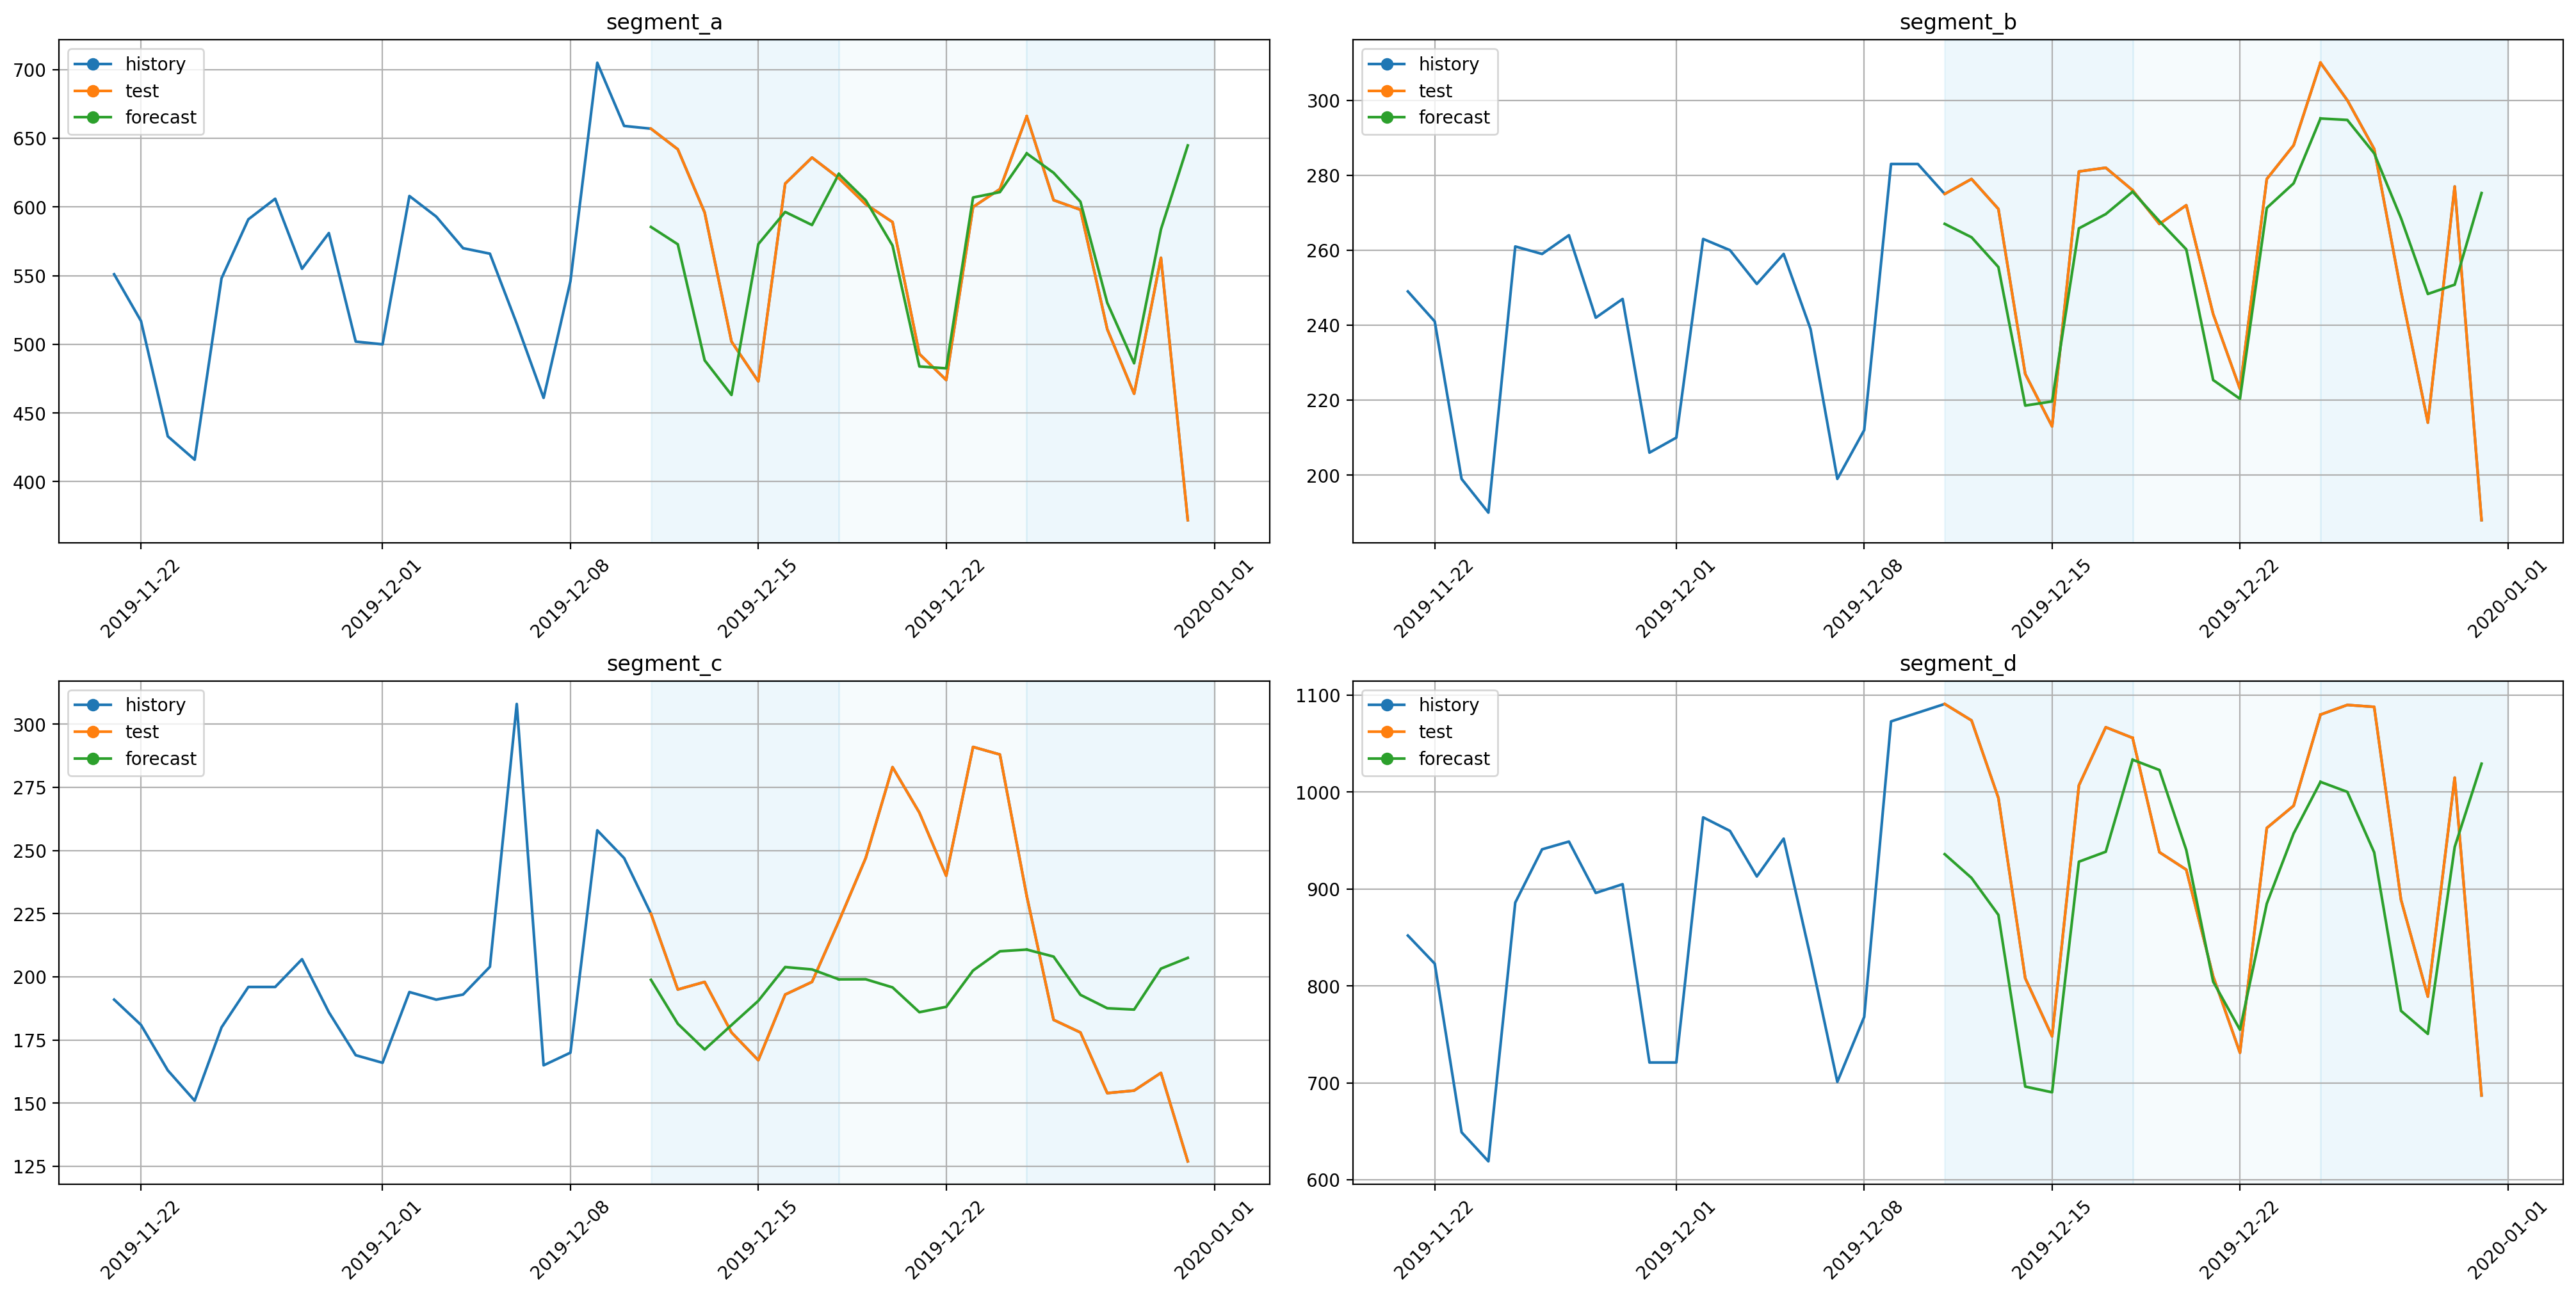

In [10]:
# визуализируем прогнозы
plot_backtest(forecast_deepar, ts, history_len=20)

In [11]:
# задаем сиды для воспроизводимости
set_seed()

# добавляем лаги и календарные признаки
transform_date = DateFlagsTransform(
    day_number_in_week=True, 
    day_number_in_month=False, 
    out_column='dateflag')

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag',
)
lag_columns = [f'target_lag_{HORIZON+i}' for i in range(num_lags)]

# сформируем TimeSeriesDataSet - служебный набор PyTorch для обучения
dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=['time_idx'] + lag_columns,
    time_varying_unknown_reals=['target'],
    time_varying_known_categoricals=['dateflag_day_number_in_week'],
    target_normalizer=GroupNormalizer(groups=['segment']),
)

In [12]:
# создаем модель DeepAR, передав в нее TimeSeriesDataSet - 
# служебный набор PyTorch для обучения
model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=150, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64,
)

# создаем конвейер
pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date]
)

# выполняем перекрестную проверку расширяющимся окном
metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(
    ts, metrics=metrics, n_folds=3, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.0min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.3min remaining:    0.0s
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 35    
3 | rnn                    | LSTM                   | 2.2 K 
4 | distribution_projector | Linear                 | 22    
------------------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


In [13]:
# смотрим метрики по сегментам
metrics_deepar

,segment,SMAPE,MAPE,MAE,fold_number
3,segment_a,7.277709,6.964051,42.293631,0
3,segment_a,1.891518,1.912201,10.768947,1
3,segment_a,14.006443,15.571162,73.251081,2
2,segment_b,5.668997,5.493140,14.710290,0
2,segment_b,4.814452,4.627862,11.873132,1
2,segment_b,12.500322,13.601460,31.668052,2
0,segment_c,6.992120,7.180755,13.951941,0
0,segment_c,30.890688,26.445891,70.763805,1
0,segment_c,20.709583,26.230423,39.291650,2
1,segment_d,11.333176,10.658790,106.796640,0


In [14]:
# вычислим усредненное значение SMAPE
score = metrics_deepar['SMAPE'].mean()
print(f"Усредненное значение SMAPE для DeepAR: {score:.3f}")

Усредненное значение SMAPE для DeepAR: 11.837


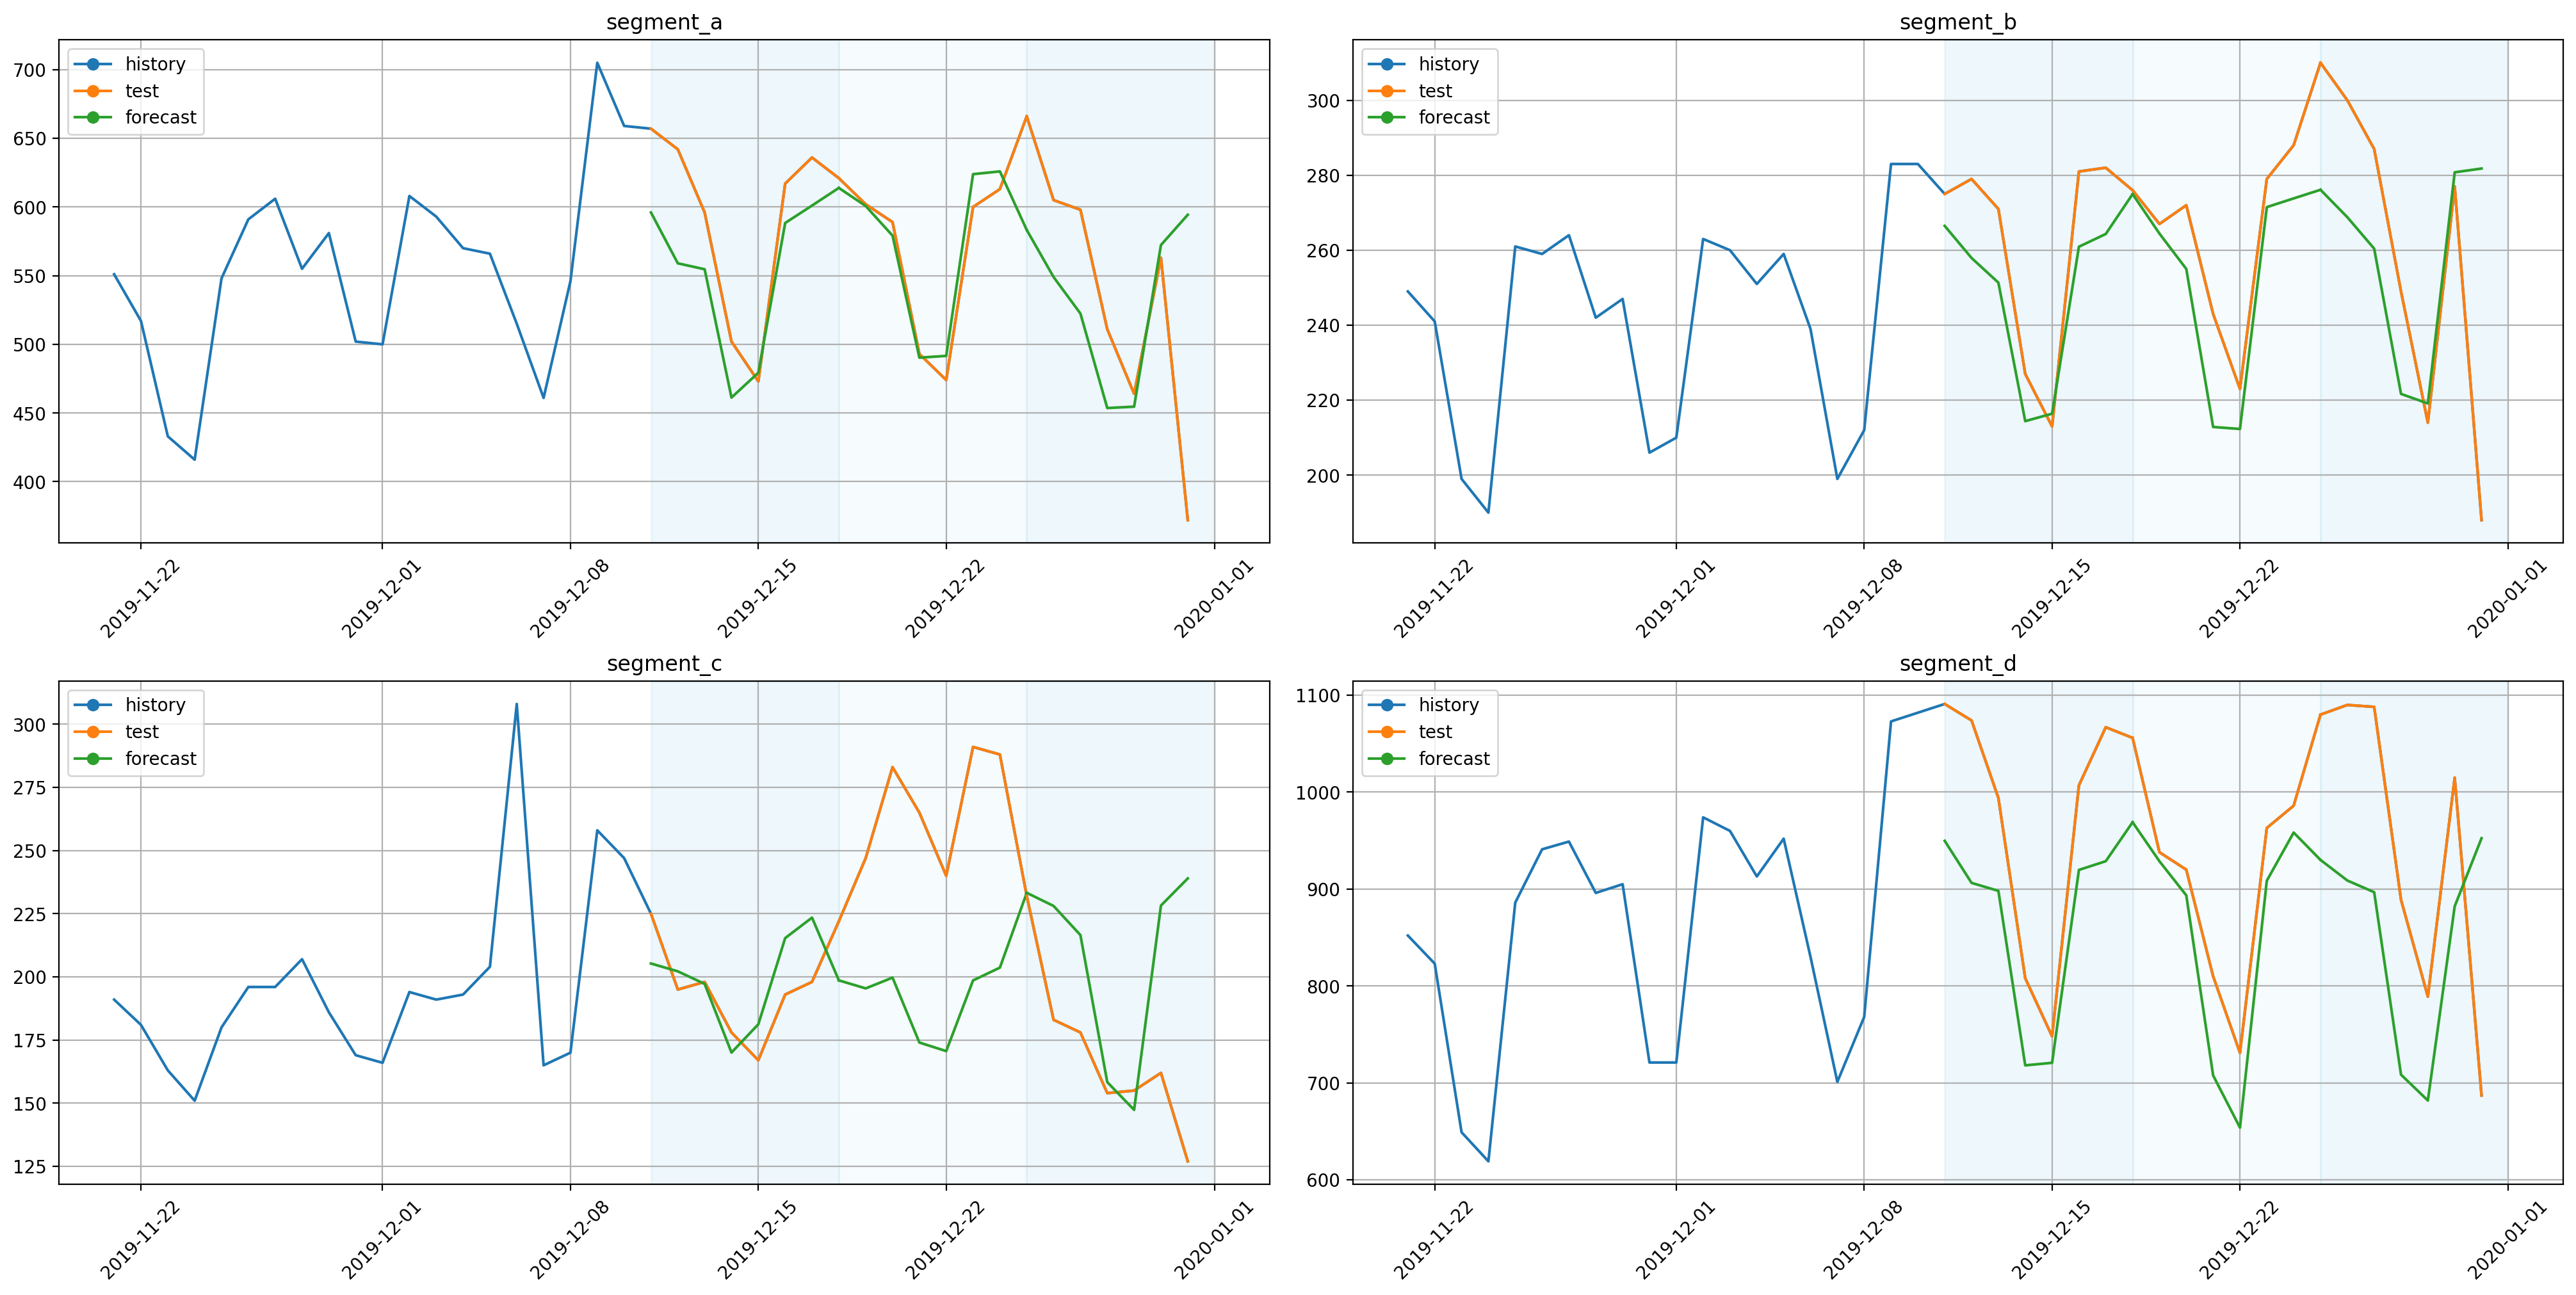

In [15]:
# визуализируем прогнозы
plot_backtest(forecast_deepar, ts, history_len=20)